#1. IMPORTING LIBRARIES

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

#2. LOAD DATA

In [10]:
fear_greed = pd.read_csv('/content/fear_greed_index.csv')
trades = pd.read_csv('/content/historical_data.csv')
print("Fear & Greed Shape:", fear_greed.shape)
print("Trades Shape:", trades.shape)

Fear & Greed Shape: (2644, 4)
Trades Shape: (211224, 16)


# Parse dates

In [11]:
fear_greed['date'] = pd.to_datetime(fear_greed['date'], format='%d-%m-%Y')
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce')

# Create common date column

In [12]:
trades['date'] = trades['Timestamp IST'].dt.date
trades['date'] = pd.to_datetime(trades['date'])
print("Fear & Greed Columns:", fear_greed.columns)
print("Trades Columns:", trades.columns)

Fear & Greed Columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Trades Columns: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date'],
      dtype='object')


# 3. MERGE DATASETS

In [13]:
df = trades.merge(fear_greed, on='date', how='inner')
df = df.dropna(subset=['Closed PnL', 'Size USD'])
print("Merged Shape:", df.shape)

Merged Shape: (35864, 20)


# 4. PROFITABILITY ANALYSIS

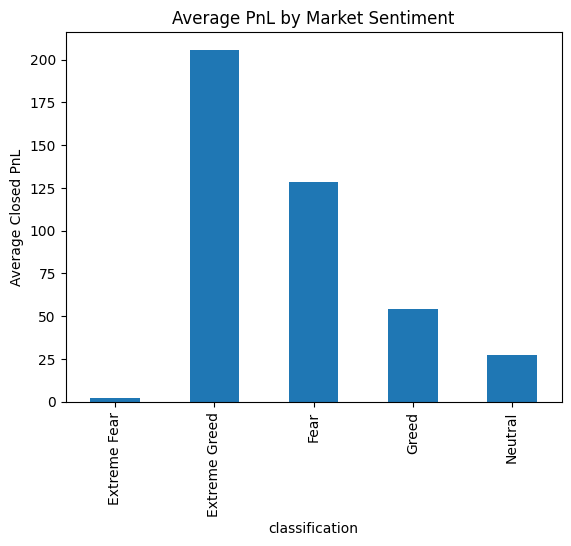

In [16]:
import os
pnl_by_sent = df.groupby('classification')['Closed PnL'].mean()
plt.figure()
pnl_by_sent.plot(kind='bar')
plt.title('Average PnL by Market Sentiment')
plt.ylabel('Average Closed PnL')
output_dir = '/content/outputs/'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'pnl_vs_sentiment.png'))
plt.show()

# 5. VOLUME / EXPOSURE ANALYSIS

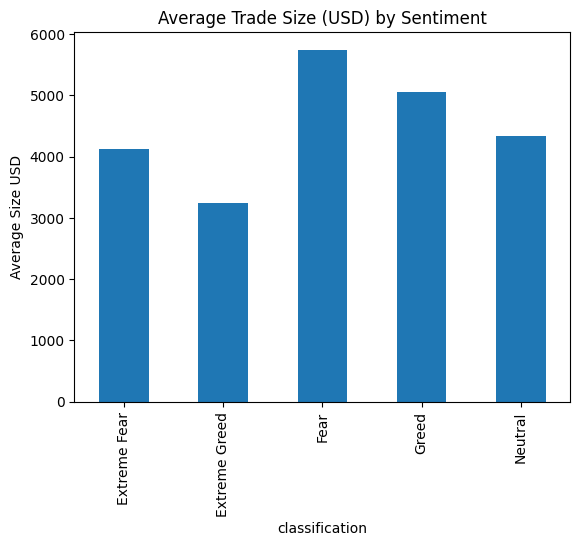

In [17]:
volume_by_sent = df.groupby('classification')['Size USD'].mean()
plt.figure()
volume_by_sent.plot(kind='bar')
plt.title('Average Trade Size (USD) by Sentiment')
plt.ylabel('Average Size USD')
plt.savefig('/content/outputs/volume_vs_sentiment.png')
plt.show()


# 6. RISK ANALYSIS (PNL VOLATILITY)

In [ ]:
risk_by_sent = df.groupby('classification')['Closed PnL'].std()
plt.figure()
risk_by_sent.plot(kind='bar')
plt.title('PnL Volatility (Risk) by Sentiment')
plt.ylabel('Std Dev of Closed PnL')
plt.savefig('/content/outputs/risk_vs_sentiment.png')
plt.show()

# 7. TAIL RISK (LARGE LOSSES)

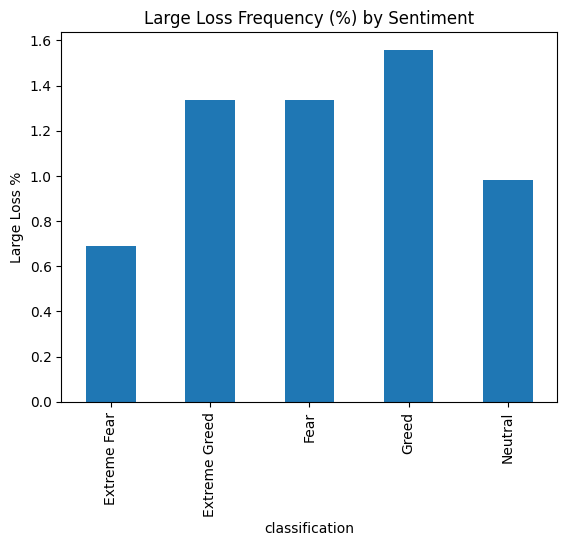

In [18]:
df['large_loss'] = df['Closed PnL'] < -100  # Threshold for big loss
tail_risk = df.groupby('classification')['large_loss'].mean() * 100
plt.figure()
tail_risk.plot(kind='bar')
plt.title('Large Loss Frequency (%) by Sentiment')
plt.ylabel('Large Loss %')
plt.savefig('/content/outputs/tailloss_vs_sentiment.png')
plt.show()

# 8. WIN RATE ANALYSIS

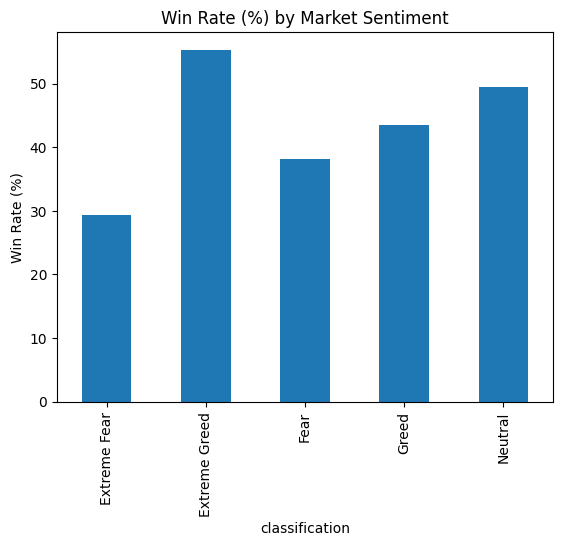

In [19]:
df['win'] = df['Closed PnL'] > 0
winrate = df.groupby('classification')['win'].mean() * 100
plt.figure()
winrate.plot(kind='bar')
plt.title('Win Rate (%) by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.savefig('/content/outputs/winrate_vs_sentiment.png')
plt.show()

9. LEVERAGE / EXPOSURE PROXY

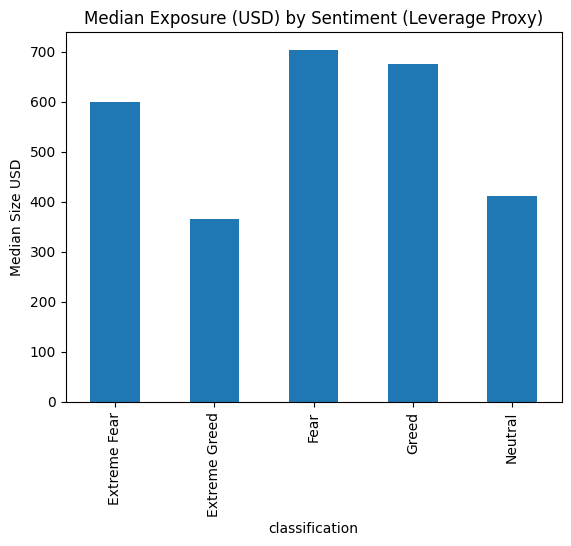

In [20]:
exposure_by_sent = df.groupby('classification')['Size USD'].median()
plt.figure()
exposure_by_sent.plot(kind='bar')
plt.title('Median Exposure (USD) by Sentiment (Leverage Proxy)')
plt.ylabel('Median Size USD')
plt.savefig('/content/outputs/exposure_vs_sentiment.png')
plt.show()

# 10. HIDDEN TRENDS (ROLLING PNL SIGNAL)

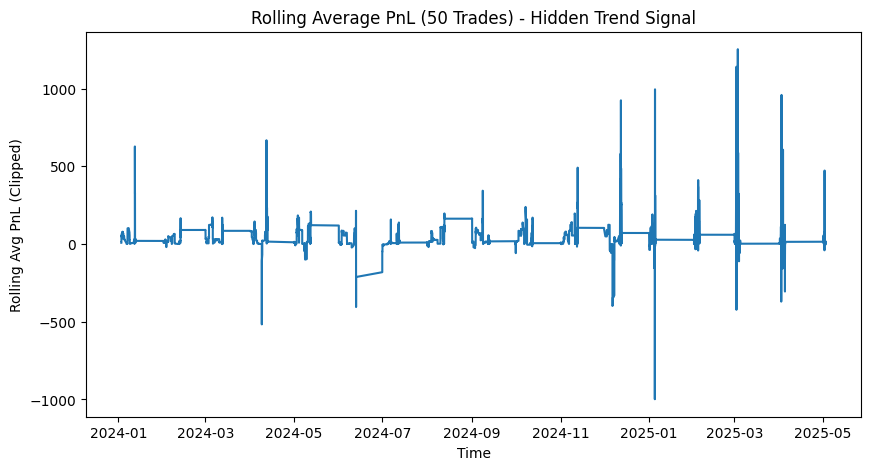

In [22]:
df = df.sort_values('Timestamp IST')
df['pnl_clipped'] = df['Closed PnL'].clip(lower=-2000, upper=2000)
df['rolling_pnl_50'] = df['pnl_clipped'].rolling(50).mean()
plt.figure(figsize=(10,5))
plt.plot(df['Timestamp IST'], df['rolling_pnl_50'])
plt.title('Rolling Average PnL (50 Trades) - Hidden Trend Signal')
plt.xlabel('Time')
plt.ylabel('Rolling Avg PnL (Clipped)')
plt.savefig('/content/outputs/rolling_pnl_trend.png')
plt.show()


# 11. SUMMARY TABLE FOR REPORT

In [23]:
summary = df.groupby('classification').agg(
    avg_pnl=('Closed PnL', 'mean'),
    pnl_volatility=('Closed PnL', 'std'),
    avg_trade_size=('Size USD', 'mean'),
    win_rate_pct=('win', 'mean'),
    large_loss_pct=('large_loss', 'mean')
)

summary['win_rate_pct'] *= 100
summary['large_loss_pct'] *= 100

print("\n=== FINAL SUMMARY TABLE ===")
print(summary)
summary.to_csv('/content/outputs/summary_by_sentiment.csv')


=== FINAL SUMMARY TABLE ===
                   avg_pnl  pnl_volatility  avg_trade_size  win_rate_pct  \
classification                                                             
Extreme Fear      1.891632       76.727713     4118.761840     29.277730   
Extreme Greed   205.816345     1861.557119     3242.085086     55.328233   
Fear            128.287950     1342.348497     5744.782685     38.178672   
Greed            53.988003     1399.468182     5051.878829     43.570670   
Neutral          27.088803      142.945889     4332.202906     49.492017   

                large_loss_pct  
classification                  
Extreme Fear          0.687876  
Extreme Greed         1.334282  
Fear                  1.333910  
Greed                 1.558626  
Neutral               0.979681  
